# Windy Gridworld (Exercise 6.4 in Sutton & Barto)

Here we study a standard gridworld problem with start and goal states, but there is a crosswind upward through the middle of the grid. There are four standard actions: up, down, right and left - but in the middle region the resultant next states are shifted upward by a 'wind', the strength of which varies from column to column. We treat this problem as an undiscounted task, with constant reward of -1 until the goal state is reached.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
C, R = 10, 7                           # number of columns and rows
Sc, Sr, Gc, Gr = 0, 3, 7, 3            # coordinates of start and goal states
ws = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]    # wind strength

ep = .1                                # epsilon-greediness
gamma = 1                              # discount
alpha = .5                             # learning rate
Rw = -1                                # fixed reward for each step

First we need to define the dynamics of the windy gridworld, i.e. mapping from a state and an action to a new state. For model-free control this information is not known by the learning algorithm. For this problem specifically, the dynamics/mapping is deterministic.

In [3]:
def dynamics(r, c, a):
    
    # action: 0 = up, 1 = down, 2 = right, 3 = left
    r_new, c_new = r, c
    
    if a == 0:
        r_new = min(r + 1, R - 1)
        
    elif a == 1:
        r_new = max(r - 1, 0)
        
    elif a == 2:
        c_new = min(c + 1, C - 1)
        
    elif a == 3:
        c_new = max(c - 1, 0)
        
    else:
        print('action out of range!')
     
    r_new = min(r_new + ws[c], R - 1)
    
    return r_new, c_new

# test cases
rr, cc = 3, 0
print(dynamics(rr, cc, 0))
print(dynamics(rr, cc, 1))
print(dynamics(rr, cc, 2))
print(dynamics(rr, cc, 3))

(4, 0)
(2, 0)
(3, 1)
(3, 0)


Below we define the $\varepsilon$-greedy algorithm used to pick action based on current action value estimates (acting random with $\varepsilon$ probability and pick the highest action value with probability $1-\varepsilon$).

In [4]:
import random

def valid_moves(r, c):
    
    # identify invalid actions (move past walls)
    actions = list(range(4))
    if r == 0:
        actions.remove(1)
    elif r == R - 1:
        actions.remove(0)
        
    if c == 0:
        actions.remove(3)
    elif c == C - 1:
        actions.remove(2)
        
    return actions


def ep_greedy(r, c, Q):
    
    # identify invalid actions (move past walls)
    actions = valid_moves(r, c)
        
    # extract action values
    action_v = list(Q[r, c, actions])
    
    # pick action using an epsilon-greedy strategy
    if (np.random.rand() < ep):
        # randomly choose an action
        a = random.choice(actions)
    else:
        # greedy approach
        a = actions[action_v.index(max(action_v))]
        
    return a

Now we implement the sarsa(0) algorithm for 170 episodes.

In [5]:
# Sarsa algorithm
Q = np.zeros((R, C, 4))          # initialize action state value lookup table
Q[Gr, Gc, :] = 0                # set Q(terminal state, a) = 0 for all a
max_eps = 500
steps = [0]
for eps in range(max_eps):
    num_steps = 0
    c, r = Sc, Sr
    T = False
    a = ep_greedy(c, r, Q)
    while T is False:
        rp, cp = dynamics(r, c, a)
        ap = ep_greedy(rp, cp, Q)
        Q[r, c, a] = Q[r, c, a] + alpha*(Rw + gamma*Q[rp, cp, ap] - Q[r, c, a])
        r, c = rp, cp
        a = ap
        if r == Gr and c == Gc:
            T = True
        num_steps += 1
        
    steps.append(num_steps)

Here we plot the number of episodes vs. total time steps (Figure 6.4 in Sutton & Barto). The increasing slope of the graph shows that the goal is reached more and more quickly.

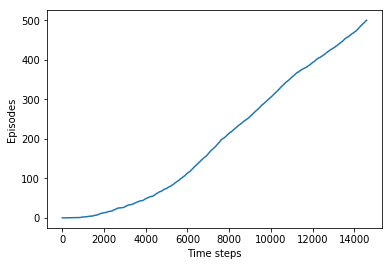

In [6]:
plt.figure()
plt.plot(np.cumsum(np.array(steps)), np.arange(max_eps + 1))
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.show()

Next we plot the action values at each grid location.

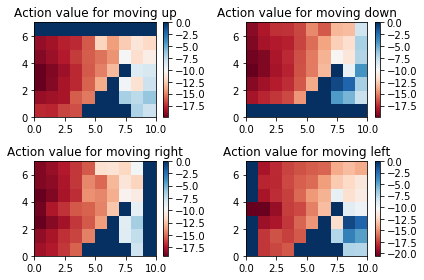

In [7]:
f, axarr = plt.subplots(2, 2)
im0 = axarr[0, 0].pcolor(Q[:,:,0], cmap='RdBu')
axarr[0, 0].set_title('Action value for moving up')
f.colorbar(im0, ax=axarr[0, 0])

im1 = axarr[0, 1].pcolor(Q[:,:,1], cmap='RdBu')
axarr[0, 1].set_title('Action value for moving down')
f.colorbar(im1, ax=axarr[0, 1])

im2 = axarr[1, 0].pcolor(Q[:,:,2], cmap='RdBu')
axarr[1, 0].set_title('Action value for moving right')
f.colorbar(im2, ax=axarr[1, 0])

im3 = axarr[1, 1].pcolor(Q[:,:,3], cmap='RdBu')
axarr[1, 1].set_title('Action value for moving left')
f.colorbar(im3, ax=axarr[1, 1])

plt.tight_layout()
plt.show()

Finally we plot the optimal policy:

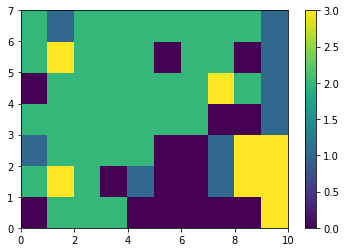

In [8]:
Q_op = np.zeros((R, C))
ep = 0
for r in range(R):
    for c in range(C):
        Q_op[r, c] = ep_greedy(r, c, Q)

plt.pcolor(Q_op)
plt.colorbar()
plt.show()